In [1]:
from omegaconf import OmegaConf as om
from scgpt.model import ComposerSCGPTModel
from scgpt.tasks import get_batch_cell_embeddings
from scgpt.tokenizer import GeneVocab
import torch
import scanpy as sc
import numpy as np
import os
from typing import Optional
import gc


from scgpt.model import SCGPTModel
from omegaconf import DictConfig
from tqdm.auto import tqdm
from scgpt.data import DataCollator, CountDataset

/home/shreshth/miniforge3/envs/composer_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_paths= {
"scgpt-70m-2048": "/vevo/scgpt/checkpoints/release/scgpt-70m-2048/",
"scgpt-70m-1024": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024/",
"scgpt-70m-1024-cell-cond": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024-cell-cond/",
"scgpt-70m-1024-right-bin": "/vevo/scgpt/checkpoints/release/scgpt-70m-1024-right-bin"
} 
# At the moment only these 4 models have been prepared for inference
# For a new model, the wandb config needs to be split into model and collator configs and the latest
# checkpoint needs to be saved in the folder as best-model.pt

model_name = "scgpt-70m-2048"

In [3]:
model_config_path = os.path.join(model_paths[model_name], "model_config.yml")
vocab_path = os.path.join(model_paths[model_name], "vocab.json")
collator_config_path = os.path.join(model_paths[model_name], "collator_config.yml")
model_file =  os.path.join(model_paths[model_name], "best-model.pt")

In [4]:
model_config = om.load(model_config_path)
collator_config = om.load(collator_config_path)
vocab = GeneVocab.from_file(vocab_path)

model = ComposerSCGPTModel(model_config = model_config,
                          collator_config = collator_config)

In [5]:
model.load_state_dict(torch.load(model_file)["state"]["model"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

ComposerSCGPTModel(
  (model): SCGPTModel(
    (gene_encoder): GeneEncoder(
      (embedding): Embedding(60736, 512, padding_idx=60694)
    )
    (flag_encoder): Embedding(2, 512)
    (expression_encoder): ContinuousValueEncoder(
      (dropout): Dropout(p=0.1, inplace=False)
      (linear1): Linear(in_features=1, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=512, bias=True)
    )
    (transformer_encoder): SCGPTEncoder(
      (layers): ModuleList(
        (0-11): 12 x SCGPTBlock(
          (self_attn): GroupedQueryAttention(
            (Wqkv): Linear(in_features=512, out_features=1536, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (up_proj): Linear(in_features=512, out_features=2048, bias=True)
          (down_proj): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e

In [7]:
with torch.no_grad(), torch.cuda.amp.autocast(enabled=True, dtype=torch.bfloat16):
    gene2idx = vocab.get_stoi()
    all_gene_ids = np.array([[id for id in gene2idx.values()]])
    chunk_size = 30000  # Size of each chunk, >30000 OOMs

    # Initialize an empty array to hold the final embeddings.
    # Assuming 'num_genes' is the total number of genes.
    # This should be equivalent to len(all_gene_ids.flatten()) in your case.
    num_genes = all_gene_ids.shape[1]
    gene_embeddings_ctx_free = np.ones((num_genes, 
                                         model_config["d_model"])) *np.nan
    # Update output_size accordingly

    for i in range(0, num_genes, chunk_size):
        chunk_gene_ids = all_gene_ids[:, i:i+chunk_size]
        chunk_gene_ids_tensor = torch.tensor(chunk_gene_ids, dtype=torch.long).to(device)

        token_embs = model.model.gene_encoder(chunk_gene_ids_tensor)
        flag_embs = model.model.flag_encoder(
            torch.tensor(1, device=token_embs.device)
        ).expand(chunk_gene_ids_tensor.shape[0], chunk_gene_ids_tensor.shape[1], -1)

        total_embs = token_embs + flag_embs
        chunk_embeddings = model.model.transformer_encoder(total_embs)
        chunk_embeddings_cpu = chunk_embeddings.to("cpu").numpy()

        # Assigning the chunk embeddings to the correct place in the full array.
        gene_embeddings_ctx_free[i:i+chunk_size] = chunk_embeddings_cpu

In [8]:
torch.cuda.empty_cache()

In [10]:
sample_data_path = '/vevo/scgpt/datasets/samples/Kim2020_Lung.h5ad'
sample_data_path = "/vevo/cellxgene/msigdb_gene_emb_subset/rep_1.h5ad.gz"
adata = sc.read_h5ad(sample_data_path)

gene_col = "feature_name"
cell_type_key = "cell_type"
batch_key = "dataset_id"
N_HVG = 20000

In [12]:
celltype_id_labels = adata.obs[cell_type_key].astype("category").cat.codes.values
adata = adata[celltype_id_labels >= 0]
org_adata = adata.copy()
# highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]

/home/shreshth/miniforge3/envs/composer_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "seurat_v3"}


In [13]:
adata.var["id_in_vocab"] = [
    vocab[gene] if gene in vocab else -1 for gene in adata.var[gene_col]
]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
print(
    f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
    f"in vocabulary of size {len(vocab)}."
)
adata = adata[:, adata.var["id_in_vocab"] >= 0]

vocab.set_default_index(vocab["<pad>"])
genes = adata.var[gene_col].tolist()
gene_ids = np.array(vocab(genes), dtype=int)

/tmp/ipykernel_2323295/55725197.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["id_in_vocab"] = [


match 20000/20000 genes in vocabulary of size 60736.


In [14]:
sc.pp.filter_cells(adata, min_genes=3)

/home/shreshth/miniforge3/envs/composer_env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [15]:
adata = adata[0:10000] # Filter to first 10k only for testing

In [16]:
# get cell embeddings
cell_embeddings = get_batch_cell_embeddings(
    adata=adata,
    model=model.model,
    vocab=vocab,
    gene_ids=gene_ids,
    model_cfg=model_config,
    collator_cfg=collator_config,
    batch_size=32,
)


adata.obsm["X_scGPT"] = cell_embeddings

Embedding cells: 100%|██████████| 10000/10000 [01:04<00:00, 153.97it/s]
/tmp/ipykernel_2323295/489859615.py:13: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


/home/shreshth/miniforge3/envs/composer_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/shreshth/miniforge3/envs/composer_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


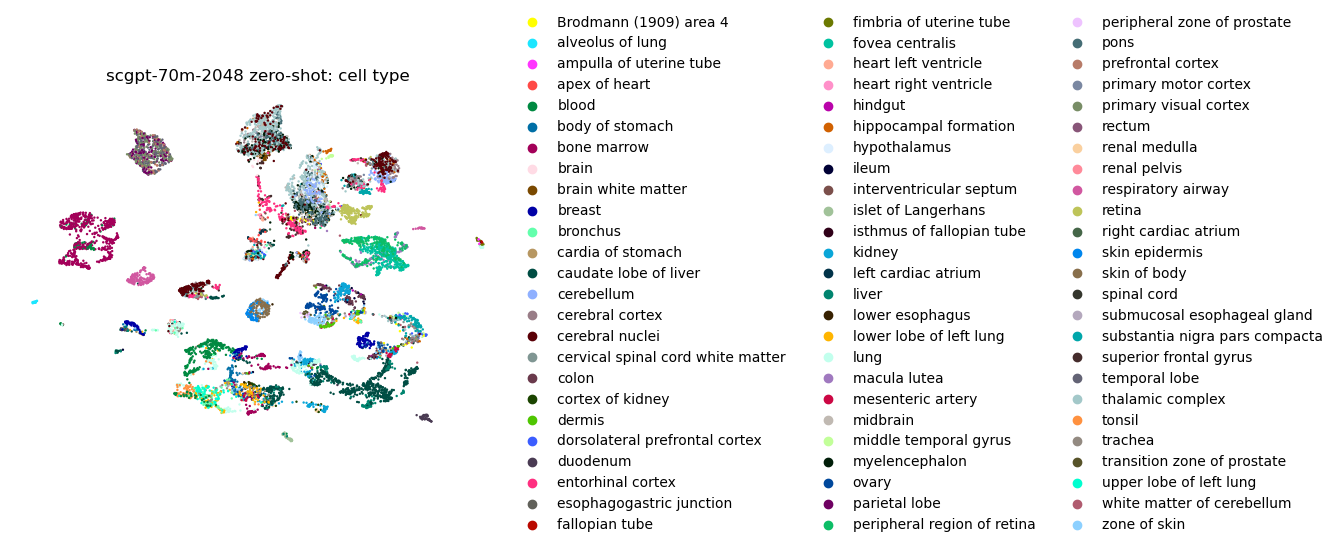

In [36]:
cell_type_key = "tissue"
sc.pl.umap(adata, 
           color=[cell_type_key], 
           frameon=False, 
           wspace=0.4, 
           title=[f"{model_name} zero-shot: cell type"])

In [18]:
def get_batch_gene_embeddings(
    adata,
    model: SCGPTModel,
    vocab: GeneVocab,
    model_cfg: DictConfig,
    collator_cfg: DictConfig,
    gene_ids: Optional[np.ndarray] = None,
    batch_size: int = 8,
    num_workers: int = 8,
    max_length: Optional[int] = None,
) -> np.ndarray:
    """
    Get the cell embeddings for a batch of cells.

    Args:
        adata (AnnData): The AnnData object.
        model (SCGPTModel): The model.
        vocab (GeneVocab): The gene-to-ID vocabulary
        model_cfg (DictConfig, optional): The model configuration dictionary.
        collator_cfg (DictConfig, optional): The collator configuration dictionary.
        gene_ids (np.ndarray, optional): The gene vocabulary ids.
            Defaults to None, in which case the gene IDs are taken from adata.var["id_in_vocab"].
        batch_size (int): The batch size for inference. Defaults to 64.
        num_workers (int): The number of workers for the data loader. Defaults to 8.

    Returns:
        np.ndarray: The cell embeddings.
    """

    count_matrix = adata.X
    count_matrix = (
        count_matrix if isinstance(count_matrix, np.ndarray) else count_matrix.A
    )

    # gene vocabulary ids
    if gene_ids is None:
        gene_ids = np.array(adata.var["id_in_vocab"])
        assert np.all(gene_ids >= 0)

    dataset = CountDataset(
        count_matrix,
        gene_ids,
        cls_token_id=vocab["<cls>"],
        pad_value=collator_cfg["pad_value"],
    )
    if max_length is None:
        max_length = len(gene_ids)
    collate_fn = DataCollator(
        do_padding=collator_cfg.get("do_padding", True),
        pad_token_id=collator_cfg.pad_token_id,
        pad_value=collator_cfg.pad_value,
        do_mlm=False,  # Disable masking for inference
        do_binning=collator_cfg.get("do_binning", True),
        mlm_probability=collator_cfg.mlm_probability,
        mask_value=collator_cfg.mask_value,
        max_length=max_length,
        sampling=False,
        data_style="pcpt",  # Disable splitting of genes into pcpt and gen for inference
        num_bins=collator_cfg.get("num_bins", 51),
        right_binning=collator_cfg.get("right_binning", False),
    )
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        drop_last=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    device = next(model.parameters()).device

    def index_search(a, x):
        match = []  # Initialize the result list
        for sublist in x:
            # For each sublist in x, find indices of its elements in a
            indices = [a.index(item) if item in a else -1 for item in sublist]
            match.append(indices)
        return match

    # Make gene embeddings
    gene_embeddings = np.zeros((len(vocab),model_cfg["d_model"]),
                               dtype=np.float32)
    # gene_embeddings[:] = np.nan
    gene_embedding_counts = np.zeros((len(vocab)), dtype=np.float32)


    
    # cell_embeddings = np.zeros((len(dataset), model_cfg["d_model"]), dtype=np.float32)
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=True, dtype=torch.bfloat16):
        count = 0
        pbar = tqdm(total=len(dataset), desc="Embedding cells")
        for data_dict in data_loader:
            input_gene_ids = data_dict["gene"].to(device)
            src_key_padding_mask = ~input_gene_ids.eq(
                collator_cfg["pad_token_id"]
            )  # Note the negation here compared to the public scGPT implementation!
            embeddings = model._encode(
                src=input_gene_ids,
                values=data_dict["expr"].to(device),
                src_key_padding_mask=src_key_padding_mask,
            )
            input_gene_ids = input_gene_ids.to("cpu").numpy()
            
            
            # Casting to float 32 avoids issues with bfloat16 -> numpy conversion for some models
            # https://github.com/pytorch/pytorch/issues/110285
            embeddings = embeddings.to("cpu").to(torch.float32).numpy()
            for emb, genes in zip(embeddings, input_gene_ids):
                gene_embeddings[genes] += emb
                gene_embedding_counts[genes] += 1
            count += len(embeddings)
            pbar.update(len(embeddings))
    gene_embedding_counts = np.expand_dims(gene_embedding_counts, axis=1)
    norm_gene_embeddings = np.divide(gene_embeddings,
                                    gene_embedding_counts,
                                    out=np.ones_like(gene_embeddings)*np.nan,
                                    where=gene_embedding_counts!=0)
    return norm_gene_embeddings


In [19]:
# get cell embeddings
gene_embeddings = get_batch_gene_embeddings(
    adata=adata,
    model=model.model,
    vocab=vocab,
    gene_ids=gene_ids,
    model_cfg=model_config,
    collator_cfg=collator_config,
    batch_size=32,
)

Embedding cells: 100%|██████████| 10000/10000 [01:30<00:00, 110.86it/s]


In [20]:
np.sum(np.mean(~np.isnan(gene_embeddings), axis=-1))


15344.0

In [21]:
nan_genes = np.where(np.any(np.isnan(gene_embeddings), axis=-1))[0]

In [23]:
len(nan_genes)

45392

In [27]:
gene_embeddings[nan_genes] = gene_embeddings_ctx_free[nan_genes]

In [28]:
gene_embeddings

array([[-0.22772695,  0.01317974,  0.2847055 , ..., -0.35723463,
        -0.77148235,  0.20027083],
       [-0.44888377,  0.05782431,  0.22282456, ..., -0.25533542,
        -0.67264116,  0.08480234],
       [-0.66152346, -0.8499608 , -0.19170457, ..., -0.16477674,
         0.32657382,  0.04781113],
       ...,
       [-0.46387622, -0.09413669,  0.69040555, ..., -0.40017295,
        -0.38064075, -0.11498835],
       [-0.51639545, -0.20593506,  0.5455333 , ..., -0.58093894,
        -0.45174095,  0.09383532],
       [-0.74543136,  0.17164695,  0.4057046 , ..., -0.30434754,
        -0.65555346,  0.0914294 ]], dtype=float32)

In [ ]:
np.savez(f"gene_embeddings_{model_name}.npz",
        gene_embeddings=gene_embeddings,
        gene_names=list(gene2idx.keys()),
        gene_ids=list(gene2idx.values()))